In [114]:
# -*- coding: utf-8 -*-
# Author: Angus Ferrell
# Date: 2024-02-09

# Importing the libraries
import mlflow
from mlflow.models import infer_signature
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pandas as pd
import dabl

mlflow.set_experiment("Housing Prices Prediction")

# Load the Housing.csv dataset
data_raw = pd.read_csv('data/Housing.csv')
target = data_raw['price']
data = data_raw.drop(['price'], axis=1)
data_raw.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


Data Processing 1 - OHE, keep all features

In [115]:
# One-hot encode the categorical features
cleaned_data_encoded = pd.get_dummies(data)
cleaned_data_encoded.head()

### Uncomment for data processing 1 ###
# train test split
X_train, X_test, y_train, y_test = train_test_split(cleaned_data_encoded, target, test_size=0.2, random_state=42)

,area,bedrooms,bathrooms,stories,parking,mainroad_no,mainroad_yes,guestroom_no,guestroom_yes,basement_no,basement_yes,hotwaterheating_no,hotwaterheating_yes,airconditioning_no,airconditioning_yes,prefarea_no,prefarea_yes,furnishingstatus_furnished,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
0,7420,4,2,3,2,0,1,1,0,1,0,1,0,0,1,0,1,1,0,0
1,8960,4,4,4,3,0,1,1,0,1,0,1,0,0,1,1,0,1,0,0
2,9960,3,2,2,2,0,1,1,0,0,1,1,0,1,0,0,1,0,1,0
3,7500,4,2,2,3,0,1,1,0,0,1,1,0,0,1,0,1,1,0,0
4,7420,4,1,2,2,0,1,0,1,0,1,1,0,0,1,1,0,1,0,0


Data Processing 2 - check for multicolinearity, remove features with high values

In [116]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = cleaned_data_encoded.columns
vif_data["VIF"] = [variance_inflation_factor(cleaned_data_encoded.values, i) for i in range(cleaned_data_encoded.shape[1])]

# Display VIF
print(vif_data)


# Remove features with high VIF > 10
high_vif_features = vif_data[vif_data["VIF"] > 10]
cleaned_data_encoded_selected = cleaned_data_encoded.drop(columns=high_vif_features["feature"])
print("Selected Features: ", cleaned_data_encoded_selected.columns)


                            feature       VIF
0                              area  1.325250
1                          bedrooms  1.369477
2                         bathrooms  1.286621
3                           stories  1.478055
4                           parking  1.212837
5                       mainroad_no       inf
6                      mainroad_yes       inf
7                      guestroom_no       inf
8                     guestroom_yes       inf
9                       basement_no       inf
10                     basement_yes       inf
11               hotwaterheating_no       inf
12              hotwaterheating_yes       inf
13               airconditioning_no       inf
14              airconditioning_yes       inf
15                      prefarea_no       inf
16                     prefarea_yes       inf
17       furnishingstatus_furnished       inf
18  furnishingstatus_semi-furnished       inf
19     furnishingstatus_unfurnished       inf
Selected Features:  Index(['area',

/Users/angus/Documents/GitHub/MLFlow/OAI-lab1/myenv2/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [117]:
### uncomment the following lines to run processing 2 ###

#adjust the size of the target based on the index of the cleaned_data_encoded_selected
#target2 = target[:len(cleaned_data_encoded_selected)]

# train test split
#X_train, X_test, y_train, y_test = train_test_split(cleaned_data_encoded_selected, target2, test_size=0.2, random_state=42)

In [118]:
# Linear Regression model
from sklearn.linear_model import LinearRegression

# Create a Linear Regression model
lr_model = LinearRegression()

# Train the model
lr_model.fit(X_train, y_train)

# Make predictions
lr_pred = lr_model.predict(X_test)

# Compute the performance metrics
rmse = np.sqrt(metrics.mean_squared_error(y_test, lr_pred))
mae = metrics.mean_absolute_error(y_test, lr_pred)
r2 = metrics.r2_score(y_test, lr_pred)


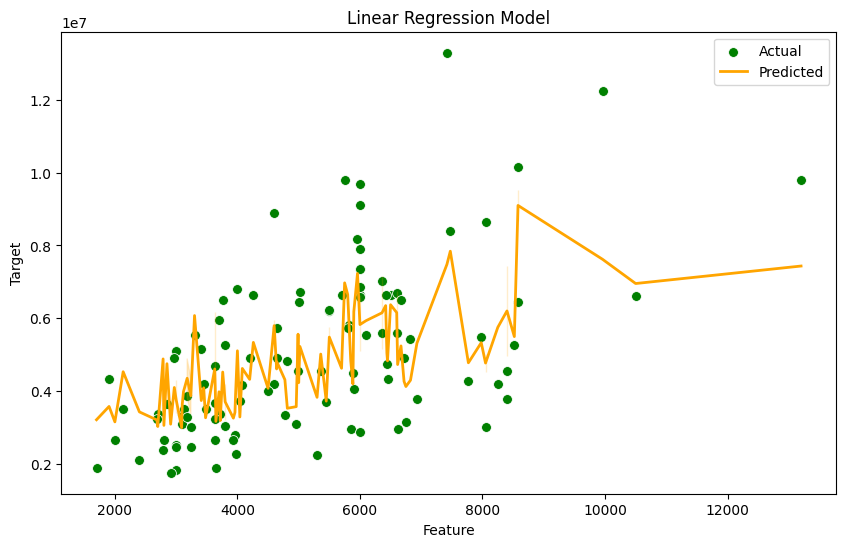

Root Mean Squared Error (RMSE): 1514173.5520492233
Mean Absolute Error (MAE): 1127483.352323519
R^2 Score: 0.5464062355495872


In [119]:
# Generate a plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_test.iloc[:, 0], y=y_test, color='green', label='Actual', s=50)
sns.lineplot(x=X_test.iloc[:, 0], y=lr_pred, color='orange', label='Predicted', linewidth=2)
plt.xlabel('Feature')
plt.ylabel('Target')
plt.title('Linear Regression Model')
plt.legend()
plt.show()

# Display performance metrics
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R^2 Score:", r2)

In [120]:

# Implement MLflow
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(lr_model.get_params())

    # Log metrics
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("r2", r2)

    # Set a tag for tracking information
    mlflow.set_tag("Training Info", "Dataset 1")

    # Infer the model signature
    signature = infer_signature(X_train, lr_model.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=lr_model,
        artifact_path="Linear_Regression_Model",
        signature=signature,
        input_example=X_train.head(),
        registered_model_name="Linear Regression Model",
    )

/Users/angus/Documents/GitHub/MLFlow/OAI-lab1/myenv2/lib/python3.9/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'Linear Regression Model' already exists. Creating a new version of this model...
Created version '11' of model 'Linear Regression Model'.


Simple Dabl Model

In [121]:
# Fit a simple regressor
simple_regressor = dabl.SimpleRegressor().fit(X_train, y_train)

# Predict the target variable
pred = simple_regressor.predict(X_test)

# Compute the performance metrics
rmse = np.sqrt(metrics.mean_squared_error(y_test, pred))
mae = metrics.mean_absolute_error(y_test, pred)
r2 = metrics.r2_score(y_test, pred)


/Users/angus/Documents/GitHub/MLFlow/OAI-lab1/myenv2/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/angus/Documents/GitHub/MLFlow/OAI-lab1/myenv2/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.385e+11, tolerance: 1.154e+11
  model = cd_fast.enet_coordinate_descent(


Running DummyRegressor()
r2: -0.007 neg_mean_squared_error: -3089159938917.093
=== new best DummyRegressor() (using r2):
r2: -0.007 neg_mean_squared_error: -3089159938917.093

Running DecisionTreeRegressor(max_depth=1)
r2: 0.322 neg_mean_squared_error: -2067751260146.771
=== new best DecisionTreeRegressor(max_depth=1) (using r2):
r2: 0.322 neg_mean_squared_error: -2067751260146.771

Running DecisionTreeRegressor(max_leaf_nodes=8)
r2: 0.484 neg_mean_squared_error: -1562902680603.966
=== new best DecisionTreeRegressor(max_leaf_nodes=8) (using r2):
r2: 0.484 neg_mean_squared_error: -1562902680603.966

Running DecisionTreeRegressor(max_leaf_nodes=16)
r2: 0.483 neg_mean_squared_error: -1513886657961.385
Running DecisionTreeRegressor(max_leaf_nodes=32)
r2: 0.400 neg_mean_squared_error: -1726299651275.710
Running DecisionTreeRegressor(max_depth=5)
r2: 0.448 neg_mean_squared_error: -1598968493780.053
Running Ridge(alpha=10)
r2: 0.489 neg_mean_squared_error: -1538771365076.771
=== new best Ridg

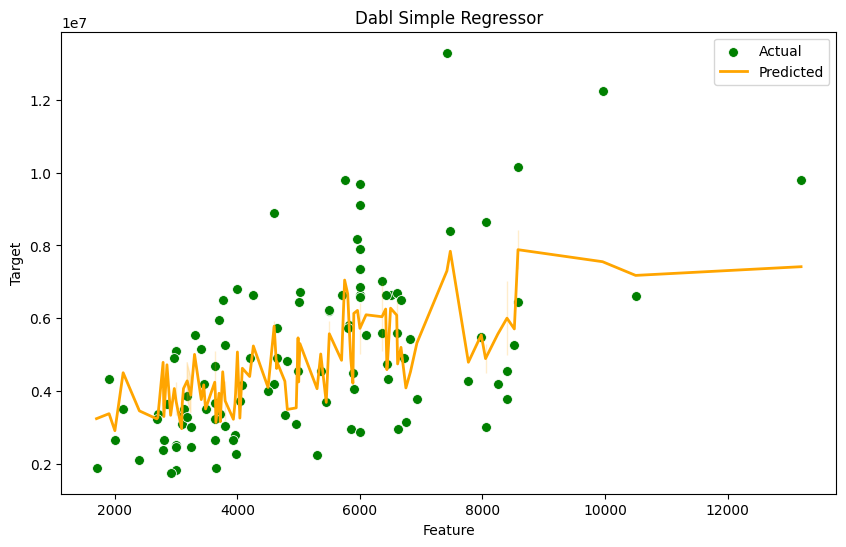

Root Mean Squared Error (RMSE): 1506089.9855805803
Mean Absolute Error (MAE): 1123723.2878009905
R^2 Score: 0.5512364189023328


In [122]:
# Generate a plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_test.iloc[:, 0], y=y_test, color='green', label='Actual', s=50)
sns.lineplot(x=X_test.iloc[:, 0], y=pred, color='orange', label='Predicted', linewidth=2)
plt.xlabel('Feature')
plt.ylabel('Target')
plt.title('Dabl Simple Regressor')
plt.legend()
plt.show()

# Display performance metrics
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R^2 Score:", r2)


In [123]:
# Implement MLflow
with mlflow.start_run():

    # Log metrics
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("r2", r2)

    # Set a tag for tracking information
    mlflow.set_tag("Training Info", "Dataset 1")

    # Infer the model signature
    signature = infer_signature(X_train, simple_regressor.predict(X_train))
    
    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=simple_regressor,
        artifact_path="Dabl_simple_regressor",
        signature=signature,
        input_example=X_train.head(),
        registered_model_name="Dabl simple regressor",
    )

/Users/angus/Documents/GitHub/MLFlow/OAI-lab1/myenv2/lib/python3.9/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'Dabl simple regressor' already exists. Creating a new version of this model...
Created version '15' of model 'Dabl simple regressor'.


Random Forest Regressor

In [124]:
# Create a base model
rf_model = RandomForestRegressor(random_state=0)

# Train the model using the best parameters
rf_model.fit(X_train, y_train)

# Predict the target variable
rf_pred = rf_model.predict(X_test)

# Compute the performance metrics
rmse = np.sqrt(metrics.mean_squared_error(y_test, rf_pred))
mae = metrics.mean_absolute_error(y_test, rf_pred)
r2 = metrics.r2_score(y_test, rf_pred)

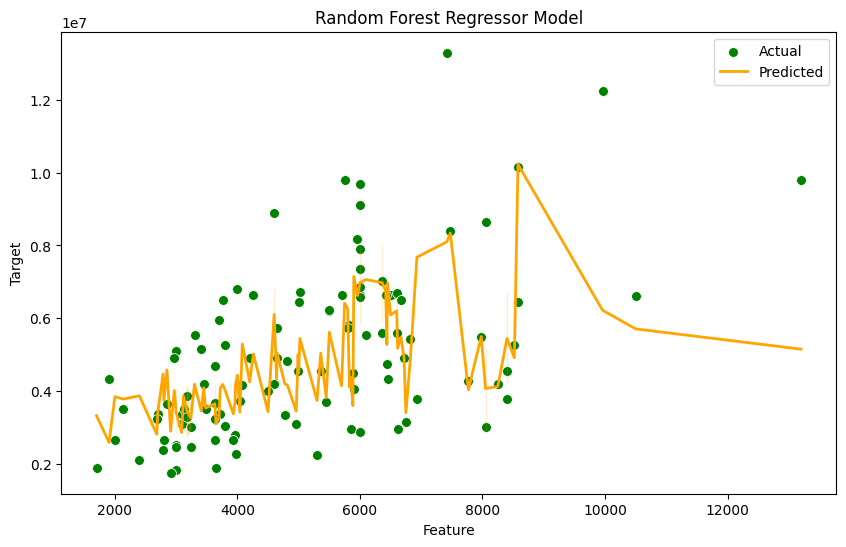

Root Mean Squared Error (RMSE): 1625515.8711564096
Mean Absolute Error (MAE): 1160912.908256881
R^2 Score: 0.47724500430390715


In [125]:
# Generate a plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_test.iloc[:, 0], y=y_test, color='green', label='Actual', s=50)
sns.lineplot(x=X_test.iloc[:, 0], y=rf_pred, color='orange', label='Predicted', linewidth=2)
plt.xlabel('Feature')
plt.ylabel('Target')
plt.title('Random Forest Regressor Model')
plt.legend()
plt.show()

# Display performance metrics
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R^2 Score:", r2)


In [126]:
# Implement MLflow
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(rf_model.get_params())

    # Log metrics
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("r2", r2)

    # Set a tag for tracking information
    mlflow.set_tag("Training Info", "Dataset 1")

    # Infer the model signature
    signature = infer_signature(X_train, rf_model.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=rf_model,
        artifact_path="Random_Forest_Model",
        signature=signature,
        input_example=X_train.head(),
        registered_model_name="Random Forest Model",
    )

/Users/angus/Documents/GitHub/MLFlow/OAI-lab1/myenv2/lib/python3.9/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'Random Forest Model' already exists. Creating a new version of this model...
Created version '11' of model 'Random Forest Model'.


Light Gradient Boost Model

In [127]:
import lightgbm as lgb

# Train the model with the best parameters
lgb_model = lgb.LGBMRegressor(random_state=0)

# Fit the model
lgb_model.fit(X_train, y_train)

# Make predictions
lgb_pred = lgb_model.predict(X_test)

# Compute the performance metrics
rmse = np.sqrt(metrics.mean_squared_error(y_test, lgb_pred))
mae = metrics.mean_absolute_error(y_test, lgb_pred)
r2 = metrics.r2_score(y_test, lgb_pred)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000796 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 123
[LightGBM] [Info] Number of data points in the train set: 436, number of used features: 5
[LightGBM] [Info] Start training from score 4706527.385321
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

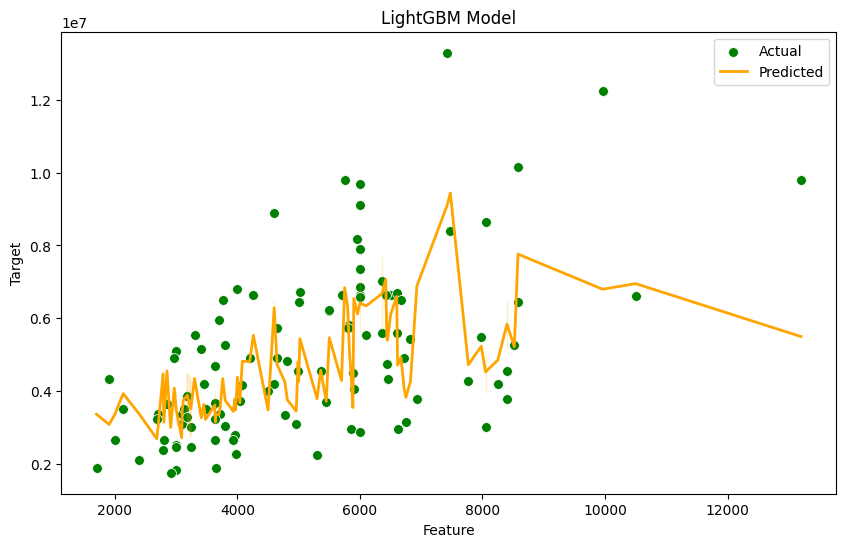

Root Mean Squared Error (RMSE): 1509663.1888506506
Mean Absolute Error (MAE): 1149333.2798228576
R^2 Score: 0.5491045068743293


In [128]:
# Generate a plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_test.iloc[:, 0], y=y_test, color='green', label='Actual', s=50)
sns.lineplot(x=X_test.iloc[:, 0], y=lgb_pred, color='orange', label='Predicted', linewidth=2)
plt.xlabel('Feature')
plt.ylabel('Target')
plt.title('LightGBM Model')
plt.legend()
plt.show()

# Display performance metrics
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R^2 Score:", r2)


In [129]:
# Implement MLflow
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(lgb_model.get_params())

    # Log metrics
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("r2", r2)

    # Set a tag for tracking information
    mlflow.set_tag("Training Info", "Dataset 1")

    # Infer the model signature
    signature = infer_signature(X_train, lgb_model.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=lgb_model,
        artifact_path="LGB_Model",
        signature=signature,
        input_example=X_train.head(),
        registered_model_name="LGB_Model",
    )

/Users/angus/Documents/GitHub/MLFlow/OAI-lab1/myenv2/lib/python3.9/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'LGB_Model' already exists. Creating a new version of this model...
Created version '12' of model 'LGB_Model'.


Ridge Regression Model

In [130]:
from sklearn.linear_model import Ridge

# Initialize the Ridge Regression model
ridge = Ridge(random_state=0)

# Train the model using the best parameters
ridge.fit(X_train, y_train)

# Get predictions
ridge_pred = ridge.predict(X_test)

# Compute the performance metrics
rmse = np.sqrt(metrics.mean_squared_error(y_test, ridge_pred))
mae = metrics.mean_absolute_error(y_test, ridge_pred)
r2 = metrics.r2_score(y_test, ridge_pred)

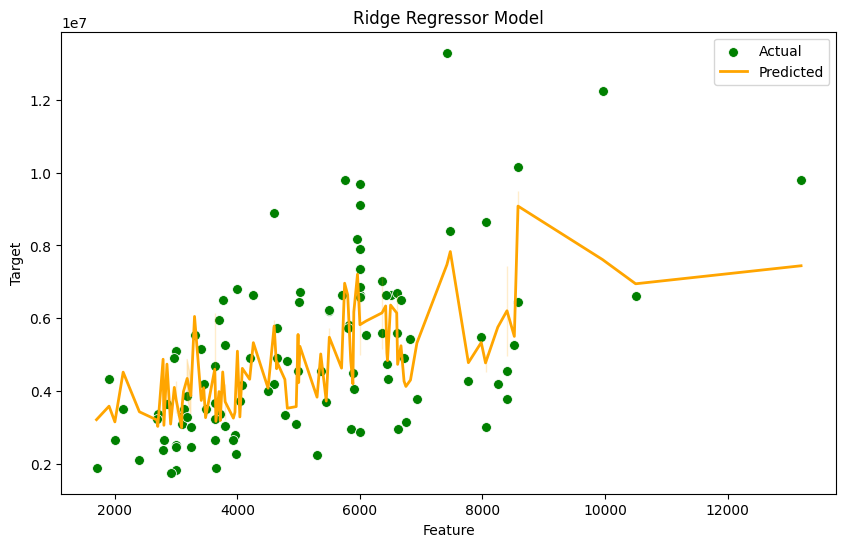

Root Mean Squared Error (RMSE): 1514047.544478292
Mean Absolute Error (MAE): 1127441.5370909874
R^2 Score: 0.5464817273849002


In [131]:
# Generate a plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_test.iloc[:, 0], y=y_test, color='green', label='Actual', s=50)
sns.lineplot(x=X_test.iloc[:, 0], y=ridge_pred, color='orange', label='Predicted', linewidth=2)
plt.xlabel('Feature')
plt.ylabel('Target')
plt.title('Ridge Regressor Model')
plt.legend()
plt.show()

# Display performance metrics
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R^2 Score:", r2)


In [132]:
# Implement MLflow
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(ridge.get_params())

    # Log metrics
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("r2", r2)

    # Set a tag for tracking information
    mlflow.set_tag("Training Info", "Dataset 1")

    # Infer the model signature
    signature = infer_signature(X_train, ridge.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=ridge,
        artifact_path="Ridge_Regression_Model",
        signature=signature,
        input_example=X_train.head(),
        registered_model_name="Ridge_Regression_Model",
    )

/Users/angus/Documents/GitHub/MLFlow/OAI-lab1/myenv2/lib/python3.9/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'Ridge_Regression_Model' already exists. Creating a new version of this model...
Created version '11' of model 'Ridge_Regression_Model'.


In [133]:
#plot the performance metrics of all the plots
metrics_df = pd.DataFrame({
    "Model": ["Linear Regression", "Dabl Simple Regressor", "Random Forest", "LightGBM", "Ridge Regression"],
    "RMSE": [0.0, 0.0, 0.0, 0.0, 0.0],
    "MAE": [0.0, 0.0, 0.0, 0.0, 0.0],
    "R^2": [0.0, 0.0, 0.0, 0.0, 0.0],
})

metrics_df.loc[0, "RMSE"] = np.sqrt(metrics.mean_squared_error(y_test, lr_pred))
metrics_df.loc[0, "MAE"] = metrics.mean_absolute_error(y_test, lr_pred)
metrics_df.loc[0, "R^2"] = metrics.r2_score(y_test, lr_pred)
metrics_df.loc[1, "RMSE"] = np.sqrt(metrics.mean_squared_error(y_test, pred))
metrics_df.loc[1, "MAE"] = metrics.mean_absolute_error(y_test, pred)
metrics_df.loc[1, "R^2"] = metrics.r2_score(y_test, pred)
metrics_df.loc[2, "RMSE"] = np.sqrt(metrics.mean_squared_error(y_test, rf_pred))
metrics_df.loc[2, "MAE"] = metrics.mean_absolute_error(y_test, rf_pred)
metrics_df.loc[2, "R^2"] = metrics.r2_score(y_test, rf_pred)
metrics_df.loc[3, "RMSE"] = np.sqrt(metrics.mean_squared_error(y_test, lgb_pred))
metrics_df.loc[3, "MAE"] = metrics.mean_absolute_error(y_test, lgb_pred)
metrics_df.loc[3, "R^2"] = metrics.r2_score(y_test, lgb_pred)
metrics_df.loc[4, "RMSE"] = np.sqrt(metrics.mean_squared_error(y_test, ridge_pred))
metrics_df.loc[4, "MAE"] = metrics.mean_absolute_error(y_test, ridge_pred)
metrics_df.loc[4, "R^2"] = metrics.r2_score(y_test, ridge_pred)
print(metrics_df)


                   Model          RMSE           MAE       R^2
0      Linear Regression  1.514174e+06  1.127483e+06  0.546406
1  Dabl Simple Regressor  1.506090e+06  1.123723e+06  0.551236
2          Random Forest  1.625516e+06  1.160913e+06  0.477245
3               LightGBM  1.509663e+06  1.149333e+06  0.549105
4       Ridge Regression  1.514048e+06  1.127442e+06  0.546482


In [134]:
!mlflow ui

[2024-02-09 19:56:36 -0500] [68403] [INFO] Starting gunicorn 21.2.0
[2024-02-09 19:56:36 -0500] [68403] [INFO] Listening at: http://127.0.0.1:5000 (68403)
[2024-02-09 19:56:36 -0500] [68403] [INFO] Using worker: sync
[2024-02-09 19:56:36 -0500] [68404] [INFO] Booting worker with pid: 68404
[2024-02-09 19:56:36 -0500] [68405] [INFO] Booting worker with pid: 68405
[2024-02-09 19:56:36 -0500] [68406] [INFO] Booting worker with pid: 68406
[2024-02-09 19:56:36 -0500] [68407] [INFO] Booting worker with pid: 68407
^C
[2024-02-09 20:04:55 -0500] [68403] [INFO] Handling signal: int
[2024-02-09 20:04:55 -0500] [68407] [INFO] Worker exiting (pid: 68407)
[2024-02-09 20:04:55 -0500] [68404] [INFO] Worker exiting (pid: 68404)
[2024-02-09 20:04:55 -0500] [68406] [INFO] Worker exiting (pid: 68406)
[2024-02-09 20:04:55 -0500] [68405] [INFO] Worker exiting (pid: 68405)
